## Bias Variance 3

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython import display
import pandas as pd
from matplotlib import cm

In [2]:
import scipy.special

def fit_legendre_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit Legendre polynomial using pseudoinverse"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_train_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_legendre_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate Legendre polynomial with given coefficients"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    return X_poly @ beta

In [3]:
random_seed=428
n_points=10
noise_level=0.2

In [4]:
def f(x): return 0.5*(x**2)

def get_noisy_data(n_points=10, noise_level=0.2, random_seed=428):
    np.random.seed(random_seed) 
    x=np.random.uniform(-2, 2, n_points)
    y=f(x)+noise_level*np.random.randn(n_points)
    return x,y

In [5]:
all_x = np.linspace(-2, 2, 128)
all_y = f(all_x)

n_train_points=int(np.floor(n_points*0.5))
n_test_points=n_points-n_train_points
x,y=get_noisy_data(n_points, noise_level, random_seed)
                   
x_train, y_train=x[:n_train_points], y[:n_train_points]
x_test, y_test=x[n_train_points:], y[n_train_points:]

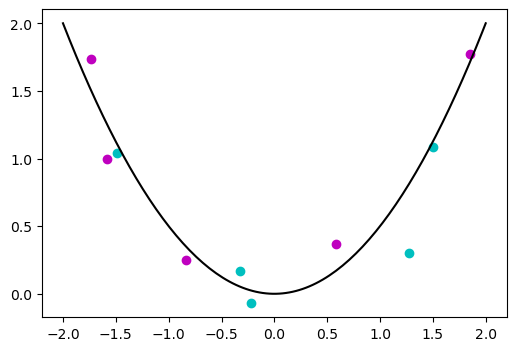

In [6]:
fig=plt.figure(0, (6, 4))
plt.plot(all_x, all_y, c='k')
plt.scatter(x_train, y_train, c='c')
plt.scatter(x_test, y_test, c='m')

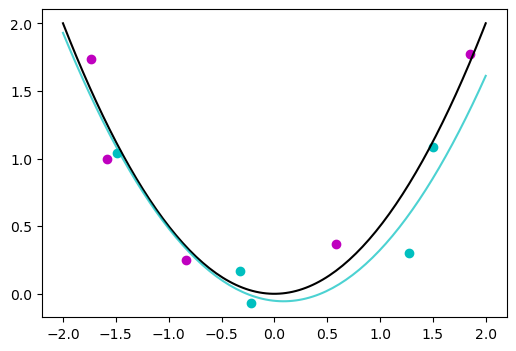

In [7]:
degree=2

beta_hat = fit_legendre_pinv(x_train, y_train, degree)
all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)

y_train_pred = eval_legendre_poly(beta_hat, x_train, degree)
y_test_pred = eval_legendre_poly(beta_hat, x_test, degree)
train_error = np.mean((y_train - y_train_pred)**2)
test_error = np.mean((y_test - y_test_pred)**2)

fig=plt.figure(0, (6, 4))
plt.plot(all_x, all_y, c='k')
plt.scatter(x_train, y_train, c='c')
plt.scatter(x_test, y_test, c='m')
plt.plot(all_x, all_y_fit, color='c', label=f'Degree {degree}', alpha=0.7)

In [8]:
fits=[]
for i in range(128):
    x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
    x_train, y_train=x[:n_train_points], y[:n_train_points]
    x_test, y_test=x[n_train_points:], y[n_train_points:]

    beta_hat = fit_legendre_pinv(x_train, y_train, degree)
    all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
    fits.append(all_y_fit)
fits=np.array(fits)

In [9]:
fits.shape

(128, 128)

(-1.0, 4.0)

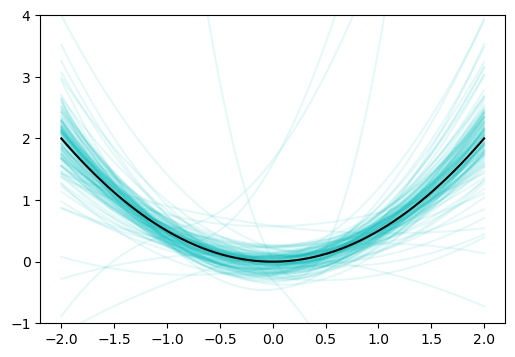

In [10]:
fig=plt.figure(0, (6, 4))
plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
plt.plot(all_x, all_y, c='k')
# plt.scatter(x_train, y_train, c='k')
# plt.scatter(x_test, y_test, c='m')
plt.ylim([-1, 4])

Ok so I think it's just this: 

In [11]:
fits.shape

(128, 128)

In [12]:
mean_fit=np.mean(fits, 0)
bias=np.mean((all_y-mean_fit)**2) #This is actually bias squared I think
variance=np.mean((fits-mean_fit)**2) #Doing 2 reductions at once, but I feel like this is maybe correct?

In [13]:
np.mean(np.var(fits, axis=0)) #How claude does it, ok yeah it's the same - cool. 

1.3811419043823228

In [14]:
bias

0.009612643197867882

In [15]:
variance

1.3811419043823225

19.411837241698386 2236.0062276897265


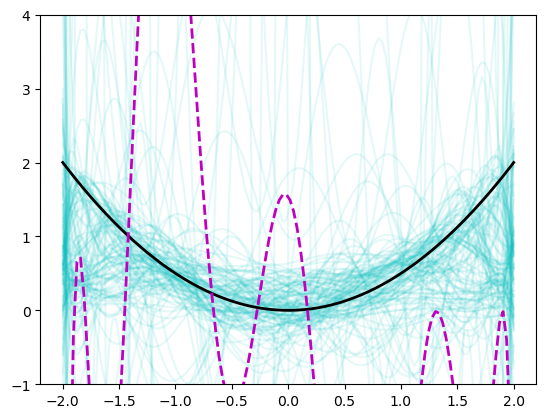

In [16]:
degree=10
n_points=10

n_train_points=int(np.floor(n_points*0.5))
n_test_points=n_points-n_train_points

fits=[]
for i in range(128):
    x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
    x_train, y_train=x[:n_train_points], y[:n_train_points]
    x_test, y_test=x[n_train_points:], y[n_train_points:]

    beta_hat = fit_legendre_pinv(x_train, y_train, degree)
    all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
    fits.append(all_y_fit)
fits=np.array(fits)

mean_fit=np.mean(fits, 0)
bias=np.mean((all_y-mean_fit)**2)
variance=np.mean((fits-mean_fit)**2) 

plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
plt.plot(all_x, all_y, c='k', linewidth=2)
plt.plot(all_x, mean_fit, 'm--', linewidth=2)
plt.ylim([-1, 4])
print(bias, variance)

In [37]:
noise_level=0.3
n_points=30
biases=[]
variances=[]
for degree in range(10):
    n_train_points=int(np.floor(n_points*0.5))
    n_test_points=n_points-n_train_points
    
    fits=[]
    for i in range(128):
        x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
        x_train, y_train=x[:n_train_points], y[:n_train_points]
        x_test, y_test=x[n_train_points:], y[n_train_points:]
    
        beta_hat = fit_legendre_pinv(x_train, y_train, degree)
        all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
        fits.append(all_y_fit)
    fits=np.array(fits)
    
    mean_fit=np.mean(fits, 0)
    bias=np.mean((all_y-mean_fit)**2)
    variance=np.mean((fits-mean_fit)**2) 
    print(degree, bias, variance)

    biases.append(bias)
    variances.append(variance)
    
    # plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
    # plt.plot(all_x, all_y, c='k', linewidth=2)
    # plt.plot(all_x, mean_fit, 'm--', linewidth=2)
    # plt.ylim([-1, 4])
    # print(bias, variance)

0 0.36822764743548453 0.027435618893575285
1 0.3729315914523153 0.08620468849204752
2 0.0003435954412802775 0.025607140709999143
3 0.00028222476780122367 0.05327518763250741
4 0.000377508255653713 0.16891491640173484
5 0.002257666452950246 2.3238434559564736
6 0.1326718018914969 26.97969650417155
7 35.08208632325723 7362.116675176178
8 14.693319512720352 12844.381035399332
9 35935.8542055105 5580921.496301578


Ok so yeah for intro let's do something like above with more points and a nicer curve. Then at the end I can either crank the degree or drop the points to make some double descent happen. 

In [40]:
noise_level=0.3
n_points=10
biases=[]
variances=[]
for degree in range(1,11):
    n_train_points=int(np.floor(n_points*0.5))
    n_test_points=n_points-n_train_points
    
    fits=[]
    for i in range(128):
        x,y=get_noisy_data(n_points, noise_level, random_seed=i)            
        x_train, y_train=x[:n_train_points], y[:n_train_points]
        x_test, y_test=x[n_train_points:], y[n_train_points:]
    
        beta_hat = fit_legendre_pinv(x_train, y_train, degree)
        all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
        fits.append(all_y_fit)
    fits=np.array(fits)
    
    mean_fit=np.mean(fits, 0)
    bias=np.mean((all_y-mean_fit)**2)
    variance=np.mean((fits-mean_fit)**2) 
    print(degree, bias, variance)

    biases.append(bias)
    variances.append(variance)
    
    # plt.plot(all_x, fits.T, color='c', label=f'Degree {degree}', alpha=0.1);
    # plt.plot(all_x, all_y, c='k', linewidth=2)
    # plt.plot(all_x, mean_fit, 'm--', linewidth=2)
    # plt.ylim([-1, 4])
    # print(bias, variance)

0 0.36811371422334527 0.0876852939295302
1 0.41244057094746955 0.39456157083561655
2 0.021628447195202717 3.107569284860226
3 0.16799428661886728 110.96940242159562
4 26625.31053522344 16254997.75480133
5 2039.428897218363 539305.189576932
6 862.8024810239413 142865.12652960647
7 299.8853996003486 39869.87044133559
8 135.6592751303228 21172.5494369295
9 85.35700190279613 9580.21364454494
10 42.59497808545643 5031.037192672796


Kinda crazy noisy, but bias and variance trending together is important/interesting!

(0.0, 500.0)

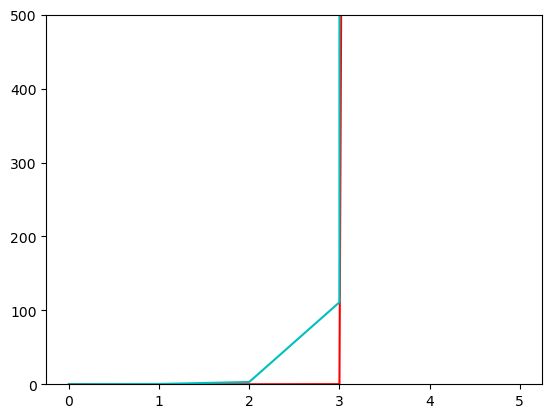

In [34]:
plt.plot(biases, 'r')
plt.plot(variances, 'c')
plt.ylim([0, 500])

- Hmm I thought my bias would just keep coming down? Is this right?
- Ah if in increase the number of points it starts to make some more sense I think?

(-1.0, 4.0)

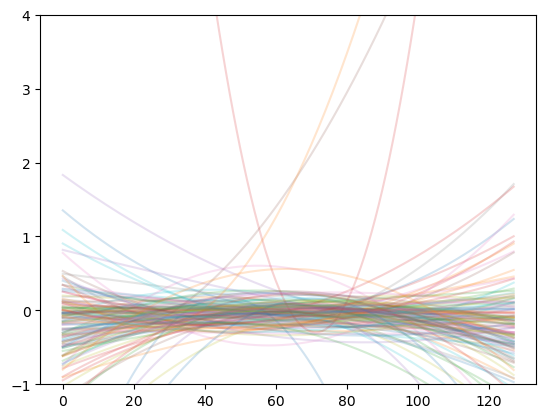

In [69]:
plt.plot((fits-mean_fit).T, alpha=0.2);
plt.ylim([-1, 4])

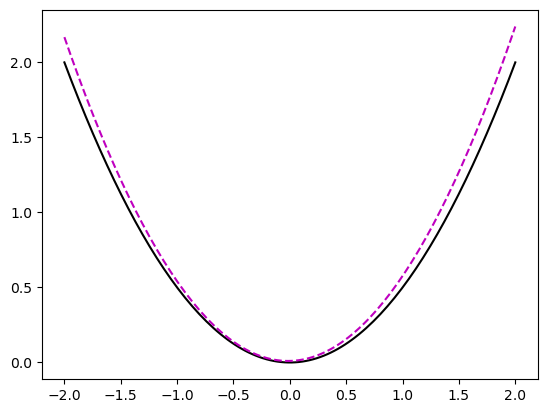

In [55]:
plt.plot(all_x, all_y, c='k')
plt.plot(all_x, mean_fit, 'm--')